Simple Health Plan Availability Study
=====================================
The aim of this notebook is to demonstrate how to use the Provider datasets to measure the quantity of medical providers in different geographic areas.

The steps needed to acomplish this are:
  1. Query the provider datasets from the individual insurers websites. This step has already been completed and the resulting sqlite file for providers in the state of michigan is available.
  2. Create a function to visualize scalar data on a map of zip-code regions.
    1. Acquire the zip-code region shape files from the census burough.
    2. Find a way to interact with the shape files
    3. Find a way to plot the shapes using matplotlib and Basemap
  3. Use the data contained in the provider sqlite file to make a count of providers available in a specific zip code.


[//]: # (TODO:)
[//]: # (ss)
[//]: # (ss)

In [22]:
%matplotlib notebook
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shapefile

First we need to read the county data shapefile and create a lookup table which will tell us where in the shapefile we can find data for different zip codes.

In [2]:
sf = shapefile.Reader("../../data/cb_2014_us_zcta510_500k/cb_2014_us_zcta510_500k")
zip_lookup = {}
for i, record in enumerate(sf.iterRecords()):
    zip_lookup[record[0]] = i

def shape_of_zip(zip_):
    return sf.shape(i=zip_lookup[zip_])

In [5]:
my_shape = shape_of_zip("68370")
print(my_shape)
print(my_shape.bbox)
print(my_shape.points[:5])

[-97.72661599999999, 40.0456, -97.369112, 40.249223]
[[-97.72661599999999, 40.219891], [-97.689647, 40.219918], [-97.689669, 40.234483], [-97.657309, 40.234556], [-97.65729499999999, 40.241658]]


Now we want to create a function to plot a set of zip code areas along with some corresponding data.

In [51]:
def plot_zips(zip_data, units="N/A", title="Title"):
    padding = 0.03
    shapes = []
    vals = []
    for zip_, val in zip_data:
        try:
            shapes.append(shape_of_zip(zip_))
            vals.append(val)
        except KeyError:
            pass
    vals = np.array(vals)
    bboxes = [shape.bbox for shape in shapes]
    llcrnrlat = min(bbox[1] for bbox in bboxes) - padding
    urcrnrlat = max(bbox[3] for bbox in bboxes) + padding
    llcrnrlon = min(bbox[0] for bbox in bboxes) - padding
    urcrnrlon = max(bbox[2] for bbox in bboxes) + padding
    fig, ax = plt.subplots()
    map_ = Basemap(llcrnrlat=llcrnrlat, llcrnrlon=llcrnrlon,
                   urcrnrlat=urcrnrlat, urcrnrlon=urcrnrlon,
                   projection='merc', resolution='i', ax=ax)
    map_.drawmapboundary(fill_color='aqua')
    map_.fillcontinents(color='tan',lake_color='aqua')
    map_.drawcoastlines()
    pols = []
    for shape in shapes:
        pols.append(np.array(list(zip(*map_(*zip(*shape.points))))))
    
    coll = mpl.collections.PolyCollection(pols, array=vals, cmap=mpl.cm.viridis, edgecolors='none', zorder=2)
    ax.add_collection(coll)
    ax.autoscale_view()
    
    ax.set_title(title)
    fig.colorbar(coll, ax=ax, label=units)

    plt.show()


Now that we have a method to plot these zip codes, lets make a plot of the zip codes of Lincoln, NE.

<IPython.core.display.Javascript object>


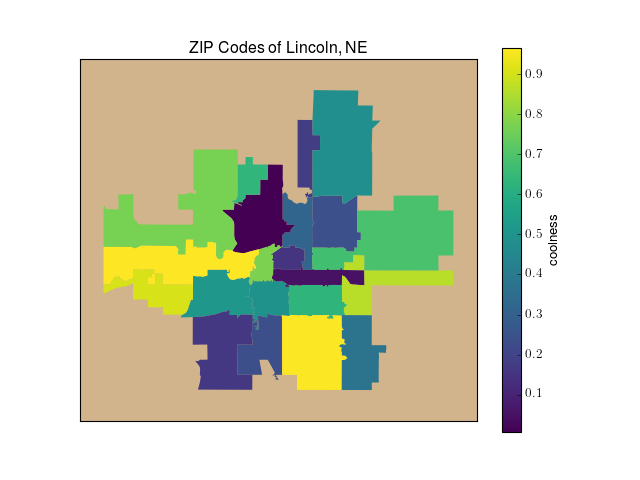

In [52]:
zips = ["68502", "68503", "68504", "68505", "68506", "68507", "68508", "68510", "68512",
        "68514", "68516", "68517", "68520", "68521", "68522", "68523", "68524", "68526", "68527", "68528",
        "68531", "68532"]
zip_data = list(zip(zips, np.random.random(len(zips))))
plot_zips(zip_data, units="coolness", title="ZIP Codes of Lincoln, NE")

In [54]:
conn = sqlite3.connect("../../data/data_mi.sqlite3")
query = ("SELECT Address.zip, COUNT(idx_provider) FROM Address "
         "WHERE Address.state='mi' "
         "GROUP BY Address.zip "
         "ORDER BY COUNT(idx_provider) DESC;")
df = pd.read_sql_query(query, conn)
df.columns = ['zip', 'zip_count']
print("Columns: {}".format(list(df)))

Columns: ['zip', 'zip_count']


<IPython.core.display.Javascript object>


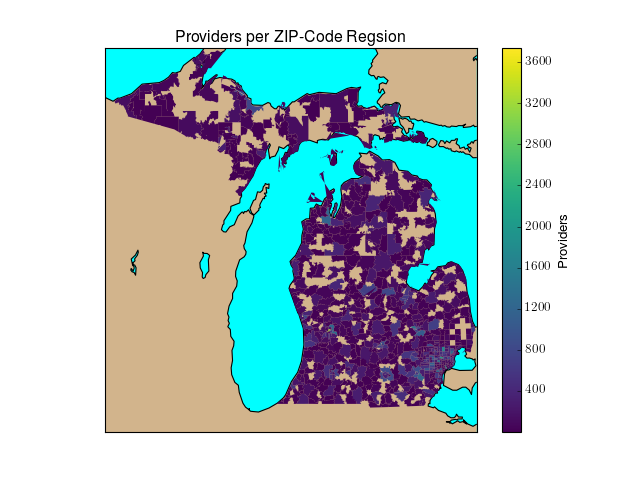

In [56]:
zip_data = list(zip(df.zip,df.zip_count))
plot_zips(zip_data, title="Providers per ZIP-Code Regsion", units="Providers")

In [ ]:
query = ("SELECT Address.zip, COUNT(idx_provider) FROM Address "
         "WHERE Address.state='mi' "
         "GROUP BY Address.zip "
         "ORDER BY COUNT(idx_provider) DESC;")
df = pd.read_sql_query(query, conn)